# RQ2: What are the popular base images?

## Load data and import libraries

In [8]:
%load_ext autoreload

# Auto reloading causes the kernel to reload the libraries we have
%autoreload 2

# usual imports for visualization, etc.
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdate
import matplotlib.ticker as ticker
import datetime
import re
from collections import OrderedDict
import matplotlib.colors as colors
from tqdm import tqdm_notebook, _tqdm_notebook

# make it reproducible
np.random.seed(0)

# show plots inline
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
data_folder = '../data/'

docker_image_dataset = pd.read_csv(data_folder + 'docker_image_dataset.csv', error_bad_lines=False, warn_bad_lines=False,low_memory=False)
dockerimage_dataset = docker_image_dataset[docker_image_dataset['collection_method'].notnull()].copy()
dockerimage_dataset.index=range(0,dockerimage_dataset.shape[0])

## Define helper functions and defaults

In [3]:
# Helper Functions
!mkdir figs
figs_dir = 'figs/'
colors_list = ['#e6194B', '#3cb44b', '#ffe119', '#4363d8', '#f58231', '#911eb4', '#42d4f4', '#f032e6', '#bfef45', '#fabebe', '#469990', '#e6beff', '#9A6324', '#800000', '#aaffc3', '#808000', '#ffd8b1', '#000075', '#a9a9a9']

mkdir: cannot create directory ‘figs’: File exists


In [4]:
from cycler import cycler
def set_plt_rc():
    SMALL_SIZE = 8
    MEDIUM_SIZE = 10
    BIGGER_SIZE = 12
    
    font = {'family': 'serif','size': BIGGER_SIZE}
    plt.rc('font', **font)

    plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
    plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
    plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
    plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
    plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
    plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
    plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
        
    plt.rc('axes', prop_cycle=(cycler(color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728',
                                         '#9467bd', '#8c564b', '#e377c2', '#7f7f7f',
                                         '#bcbd22', '#17becf']) +
                           cycler(linestyle=['-', '--', ':', '-.','-', '--', ':', '-.','-', '--'])))
    
set_plt_rc()

## Popular Docker base images

In [5]:
# Function for extracting Docker base images
def base_image_parser(dockerfile):
    result=[]
    dockerfile=dockerfile.replace('\t',' ')
    try:
        res=re.findall('(?<=FROM ).*?(?=\\n)',dockerfile,re.IGNORECASE)
        if(res==[]):
            res=re.findall('(?<=FROM ).*?(?=\\r)',dockerfile,re.IGNORECASE)
        if(res==[]):
            res=re.findall('(?<=FROM ).*',dockerfile,re.IGNORECASE)
        for item in res:
            base_image_full_name=item
            res=re.findall('.+(?= AS)',base_image_full_name,re.IGNORECASE)
            if(res!=[]):
                base_image_full_name=res[-1]
            name_split=base_image_full_name.split(':')
            base_image_name=name_split[0]
            characters=['\r','\n']
            if(len(name_split)==1):
                base_image_tag='latest'
            else:
                base_image_tag=name_split[1]
            for char in characters:
                base_image_full_name=base_image_full_name.replace(char,'')
                base_image_name=base_image_name.replace(char,'')
                base_image_tag=base_image_tag.replace(char,'')
            result.append((base_image_full_name,base_image_name,base_image_tag))
        return result
    except:
        return (np.nan,np.nan,np.nan)

In [6]:
#Use unique Dockerfiles
dockerfiles=dockerimage_dataset.iloc[dockerimage_dataset['latest_dockerfile'].drop_duplicates(keep="first").index].copy()
dockerfiles.index=range(0,dockerfiles.shape[0])

In [9]:
base_images = pd.DataFrame(columns=['image_name', 'update_year', 'base_image_name', 'base_image_tag'])
for i in tqdm_notebook(dockerfiles.index):
    result=base_image_parser(dockerfiles['latest_dockerfile'][i])
    for tup in result:
        base_images = base_images.append({'image_name': dockerfiles['image_name'][i], 'base_image_name':tup[1], 'base_image_tag':tup[2], 'update_year':pd.to_datetime(dockerfiles['pushed_at'][i]).year}, ignore_index=True)
base_images.to_csv(data_folder +'RQ2_base_images.csv',index=False)

HBox(children=(IntProgress(value=0, max=246618), HTML(value='')))

In [10]:
base_images=pd.read_csv(data_folder +'RQ2_base_images.csv', error_bad_lines=False, warn_bad_lines=False,low_memory=False)

In [13]:
base_image_name=base_images['base_image_name'].dropna()
base_image_name_proportion=base_image_name.value_counts()/len(base_image_name)*100.0
print('Top 15 most popular Docker base images')
print(base_image_name_proportion[:15])

Top 15 most popular Docker base images
ubuntu               11.659940
alpine               10.317303
node                  7.087257
debian                4.941542
python                4.659943
golang                3.623241
php                   2.931064
centos                2.784702
ruby                  2.401240
openjdk               2.221851
nginx                 1.918350
java                  1.268586
scratch               0.997417
microsoft/dotnet      0.758232
phusion/baseimage     0.684877
Name: base_image_name, dtype: float64


In [16]:
year_list=range(2014,2020)
all_base_image_name_trend=pd.DataFrame(columns=['Year','Image_Name','Proportion'])
for year in year_list:
    base=base_images[base_images['update_year']==year]
    base_proportion=base['base_image_name'].value_counts()/len(base)*100.0
    for i in range(base_proportion.size):
        all_base_image_name_trend=all_base_image_name_trend.append(pd.DataFrame([[year,base_proportion.index[i],base_proportion[i]]],columns=['Year','Image_Name','Proportion']),ignore_index=True)
# Over time
base_trend=pd.DataFrame(columns=['Year','Image_Name','Proportion'])
for year in year_list:
    base=base_images[base_images['update_year']==year]
    base_proportion=base['base_image_name'].value_counts()/len(base)*100.0
    for i in range(15):
        try:
            base_trend=base_trend.append(pd.DataFrame([[year,base_proportion.index[i],base_proportion[i]]],columns=['Year','Image_Name','Proportion']),ignore_index=True)
        except:
            continue
bs=base_trend['Image_Name'].drop_duplicates()
bs.index=range(0,bs.size)
for year in year_list:
    for i in range(0,bs.size):
        dt=base_trend.query("Year=={} and Image_Name=='{}'".format(year,bs[i]))
        if(dt.shape[0]==0):
            try:
                prop=all_base_image_name_trend.query("Year=={} and Image_Name=='{}'".format(year,bs[i]))['Proportion']
                prop=prop[prop.index[0]]
            except:
                prop=0
            base_trend=base_trend.append(pd.DataFrame([[year,bs[i],prop]],columns=['Year','Image_Name','Proportion']),ignore_index=True)

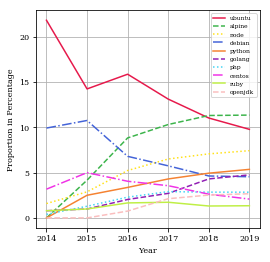

In [46]:
fig=plt.figure(figsize=(4,4))
plt.rc('font', size=8)
plt.rc('axes', titlesize=6)
plt.rc('axes', labelsize=8)
ax=plt.subplot(111)
ax.grid()
#ax.set_ylim(1,25)
bs=pd.Series(base_image_name_proportion[:10].index)
for i in range(0,bs.size):
    ax.plot(year_list, base_trend[base_trend['Image_Name']==bs[i]].sort_values(by=['Year'])['Proportion'], label=bs[i],color=colors_list[i]) 
ax.legend()
ax.set_xlabel('Year')
ax.set_ylabel('Proportion in Percentage')
ax.legend(prop=dict(size=6))
fig.savefig(figs_dir+'popular-base-images-over-time', dpi=300)
fig.savefig(figs_dir+'popular-base-images-over-time.pdf')

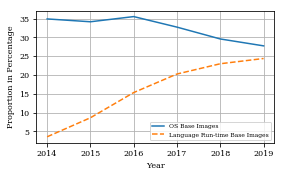

In [58]:
os_base_images=['ubuntu','alpine','debian','centos']
language_base_images=['node','python','golang','php','ruby','openjdk']
os_base_image_trend=pd.DataFrame(columns=['Year','Proportion'])
language_base_image_trend=pd.DataFrame(columns=['Year','Proportion'])
for year in year_list:
    prop=0
    for osimg in os_base_images:
        prop+=base_trend['Proportion'][base_trend.query("Year=={} and Image_Name=='{}'".format(year,osimg)).index[0]]
    os_base_image_trend = os_base_image_trend.append({'Year': year, 'Proportion':prop}, ignore_index=True)
    prop=0
    for langimg in language_base_images:
        prop+=base_trend['Proportion'][base_trend.query("Year=={} and Image_Name=='{}'".format(year,langimg)).index[0]]
    language_base_image_trend = language_base_image_trend.append({'Year': year, 'Proportion':prop}, ignore_index=True)

fig=plt.figure(figsize=(4,2.5))
plt.rc('font', size=8)
plt.rc('axes', titlesize=6)
plt.rc('axes', labelsize=8)
ax=plt.subplot(111)
ax.grid()
#ax.set_ylim(1,25)
bs=pd.Series(base_image_name_proportion[:10].index)
ax.plot(year_list, os_base_image_trend.sort_values(by=['Year'])['Proportion'], label='OS Base Images') 
ax.plot(year_list, language_base_image_trend.sort_values(by=['Year'])['Proportion'], label='Language Run-time Base Images') 
ax.legend()
ax.set_xlabel('Year')
ax.set_ylabel('Proportion in Percentage')
ax.legend(prop=dict(size=6))
fig.tight_layout()
fig.savefig(figs_dir+'os-vs-lang-over-time', dpi=300)
fig.savefig(figs_dir+'os-vs-lang-over-time.pdf')

* The proportion of OS images (Ubuntu, Debian, Centos, and Alpine) are declining.
* The porportion of language runtime (Node, Go, Python) images are increasing.

## Popular Ubuntu versions

In [18]:
ubuntu_images=base_images.query("base_image_name=='ubuntu'")
ubuntu_image_tags=ubuntu_images['base_image_tag']
ubuntu_image_tags_proportion=ubuntu_image_tags.value_counts()/len(ubuntu_image_tags)*100.0
print('Top 15 most popular tags for ubuntu base images')
print(ubuntu_image_tags_proportion[:15])

Top 15 most popular tags for ubuntu base images
16.04      30.120159
latest     17.597424
14.04      14.505501
18.04      11.353946
xenial      7.957900
trusty      5.351978
bionic      2.892155
17.10       1.353648
12.04       0.870628
16.10       0.718566
18.10       0.718566
17.04       0.676824
14.04.5     0.444259
15.10       0.417424
14.04.4     0.384627
Name: base_image_tag, dtype: float64


In [19]:
# Over time
year_list=range(2014,2020)
all_ubuntu_tag_trend=pd.DataFrame(columns=['Year','Tag_Name','Proportion'])
for year in year_list:
    tag=base_images.query("base_image_name=='ubuntu' and update_year=={}".format(year))
    tag_proportion=tag['base_image_tag'].value_counts()/len(tag)*100.0
    for i in range(tag_proportion.size):
        all_ubuntu_tag_trend=all_ubuntu_tag_trend.append(pd.DataFrame([[year,tag_proportion.index[i],tag_proportion[i]]],columns=['Year','Tag_Name','Proportion']),ignore_index=True)
# Over time
ubuntu_tag_trend=pd.DataFrame(columns=['Year','Tag_Name','Proportion'])
for year in year_list:
    tag=base_images.query("base_image_name=='ubuntu' and update_year=={}".format(year))
    tag_proportion=tag['base_image_tag'].value_counts()/len(tag)*100.0
    for i in range(15):
        try:
            ubuntu_tag_trend=ubuntu_tag_trend.append(pd.DataFrame([[year,tag_proportion.index[i],tag_proportion[i]]],columns=['Year','Tag_Name','Proportion']),ignore_index=True)
        except:
            continue
utg=ubuntu_tag_trend['Tag_Name'].drop_duplicates()
utg.index=range(0,utg.size)
for year in year_list:
    for i in range(0,utg.size):
        dt=ubuntu_tag_trend.query("Year=={} and Tag_Name=='{}'".format(year,utg[i]))
        if(dt.shape[0]==0):
            try:
                prop=all_ubuntu_tag_trend.query("Year=={} and Tag_Name=='{}'".format(year,utg[i]))['Proportion']
                prop=prop[prop.index[0]]
            except:
                prop=0
            ubuntu_tag_trend=ubuntu_tag_trend.append(pd.DataFrame([[year,utg[i],prop]],columns=['Year','Tag_Name','Proportion']),ignore_index=True)

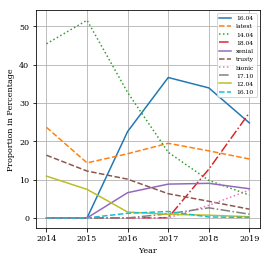

In [20]:
fig=plt.figure(figsize=(4,4))
plt.rc('font', size=8)
plt.rc('axes', titlesize=6)
plt.rc('axes', labelsize=8)
ax=plt.subplot(111)
ax.grid()
#ax.set_ylim(0,5)
utg=pd.Series(ubuntu_image_tags_proportion[:10].index)
for i in range(0,utg.size):
    ax.plot(year_list, ubuntu_tag_trend[ubuntu_tag_trend['Tag_Name']==utg[i]].sort_values(by=['Year'])['Proportion'], label=utg[i]) 
ax.legend()
ax.set_xlabel('Year')
ax.set_ylabel('Proportion in Percentage')
ax.legend(prop=dict(size=6))
fig.savefig(figs_dir+'popular-ubuntu-tags-over-time', dpi=300)
fig.savefig(figs_dir+'popular-ubuntu-tags-over-time.pdf')

* Ubuntu 14.x has reached its end of standard support date, but there are still about 9% of ubuntu images using it.

In [86]:
print('The proportion of Ubuntu 14.x in 2019: {}%'.format(ubuntu_tag_trend.query("Year==2019 and (Tag_Name=='14.04' or Tag_Name=='trusty' or Tag_Name=='14.04.3' or Tag_Name=='14.04.5' or Tag_Name=='14.04.4')")['Proportion'].sum()))

The proportion of Ubuntu 14.x in 2019: 8.87148542816793%
